In [401]:
#%reset

import tweepy
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from wordcloud import WordCloud
from nltk.util import ngrams

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.layers import Dense, Embedding, LSTM
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import text, sequence

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [402]:
# Add your Bearer token here.
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAAXMbQEAAAAA5%2BqAHvDJmPFLjU9SB87h0wyX8Dw%3DrW5cV5HUMaY0VEPcKj2UuRxmb3IemUswdUSDB8xcqN6wrle6bw')

# Create Pandas dataframe with three columns
tweet_df = pd.DataFrame(columns=['text', 'language'])

# Query tweets with #news. Show only 100 tweets
query = '#news'
tweets = client.search_recent_tweets(query=query, tweet_fields=['lang'], max_results=10)

for tweet in tweets.data:
    text = tweet.text
    language = tweet.lang

    # Focus only to tweets in english
    if language == 'en':
        tmp = [text, language]
        tweet_df.loc[len(tweet_df)] = tmp

# Total amount of tweets in dataframe
print('Amount: ', len(tweet_df))

# Show first 5 lines of dataframe
tweet_df.head()

Amount:  6


,text,language
0,RT @Planetary_Sec: 🌎\n\nApril 22 is Earth Day;...,en
1,"Tech Mahindra to create 1,000 jobs in UK\nhttp...",en
2,RT @theseiyuucafe: #NEWS | Sakamoto Maaya &amp...,en
3,RT @theseiyuucafe: #NEWS | Sakamoto Maaya &amp...,en
4,Carlos Ghosn 'surprised' by French internation...,en


In [509]:
truenews = pd.read_csv("../files/True.csv")
fakenews = pd.read_csv("../files/Fake.csv")

truenews['label'] = 1
fakenews['label'] = 0

news_df = pd.concat([truenews, fakenews])
#news_df = news_df.sample(frac = 1).reset_index(drop=True)
news_df = news_df.reset_index(drop=True)

news_df['text'] = news_df['subject'] + " " + news_df['title'] + " " + news_df['text']
del news_df['title']
del news_df['subject']
del news_df['date']
news_df.head()

,text,label
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [404]:
print("Does Twitter Dataframe contain null values: ", tweet_df.isnull().values.any())
print("Does News Dataframe contain null values: ", news_df.isnull().values.any(), "\n")

print("Twitter dataframe datatypes: \n", tweet_df.dtypes, "\n")
print("News dataframe datatypes: \n", news_df.dtypes)

Does Twitter Dataframe contain null values:  False
Does News Dataframe contain null values:  False 

Twitter dataframe datatypes: 
 text        object
language    object
dtype: object 

News dataframe datatypes: 
 text     object
label     int64
dtype: object


In [405]:
def deEmojify(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)

def clean_text(tweet):
    # Lower case text
    tweet = tweet.lower()

    # Remove mentions
    tweet = re.sub("@[A-Za-z0-9]+","", tweet)

    # Remove links
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)

    # Remove hastags
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)

    # Remove punctuations
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)

    tweet = re.sub(r"\b[a-zA-Z]\b", "", tweet)

    # Remove emoticons
    tweet = deEmojify(tweet)

    # Filter non-alphanumeric characters (double check...)
    tweet = re.sub("[^a-z0-9]"," ", tweet)

    # Tokenize tweet (split...)
    tokens = word_tokenize(tweet)

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    cleaned_tweet = ' '.join(tokens)

    return cleaned_tweet

test_text = "The @SpaceX Dragon Endeavour with four @Axiom_Space astronauts is holding 20 meters away from the station as the station crew works a video routing issue. https://nasa.gov/live"
print("Before: ", test_text)
print("After: ", clean_text(test_text))


Before:  The @SpaceX Dragon Endeavour with four @Axiom_Space astronauts is holding 20 meters away from the station as the station crew works a video routing issue. https://nasa.gov/live
After:  dragon endeavour four space astronauts hold 20 meter away station station crew work video rout issue


In [510]:
news_df['clean_text'] = np.nan
news_df['clean_text'] = [clean_text(x) for x in news_df['text']]

news_df.dropna(subset=['clean_text'], inplace=True)
news_df.drop_duplicates(subset=['text', 'clean_text'], keep=False, inplace=True)

news_df.head()

,text,label,clean_text
0,"politicsNews As U.S. budget fight looms, Repub...",1,politicsnews budget fight loom republicans fli...
1,politicsNews U.S. military to accept transgend...,1,politicsnews military accept transgender recru...
2,politicsNews Senior U.S. Republican senator: '...,1,politicsnews senior republican senator let mr ...
3,politicsNews FBI Russia probe helped by Austra...,1,politicsnews fbi russia probe help australian ...
4,politicsNews Trump wants Postal Service to cha...,1,politicsnews trump want postal service charge ...


In [511]:
tweet_df['clean_text'] = np.nan

tweet_df['clean_text'] = [clean_text(x) for x in tweet_df['text']]

tweet_df.dropna(subset=['clean_text'], inplace=True)
tweet_df.drop_duplicates(subset=['text', 'clean_text'], keep=False, inplace=True)

del tweet_df['language']

tweet_df.head()

KeyError: 'language'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(news_df['clean_text'], news_df['label'], random_state=0)

In [ ]:
maxlen = 300
max_features = 10000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(news_df['clean_text'])

def tokenize(text):
    tokenized = tokenizer.texts_to_sequences(text)
    return sequence.pad_sequences(tokenized,padding='post', maxlen=maxlen)

X_train = tokenize(X_train)
X_test = tokenize(X_test)

#tokenized = tokenizer.texts_to_sequences(news_df['clean_text'])
#news_df['sequence'] = list(sequence.pad_sequences(tokenized,padding='post', maxlen=maxlen))

news_df.head(10)

,text,label,clean_text,sequence
0,worldnews Sri Lanka parliament backs tax exemp...,1,worldnews sri lanka parliament back tax exempt...,"[159, 6539, 8014, 663, 46, 85, 6773, 2072, 105..."
1,Government News THE BRUTAL TRUTH ABOUT BENGHAZ...,0,government news brutal truth benghazi 13 hours...,"[19, 9, 2442, 778, 1754, 864, 750, 233, 1625, ..."
2,worldnews North Korea says to continue nuclear...,1,worldnews north korea say continue nuclear tes...,"[159, 97, 183, 1, 141, 246, 621, 4128, 627, 20..."
3,politicsNews Republican congressional candidat...,1,politicsnews republican congressional candidat...,"[959, 1165, 2955, 5839, 135, 9313, 7939, 225, ..."
4,politicsNews Virginia governor signs order res...,1,politicsnews virginia governor sign order rest...,"[4159, 268, 125, 164, 1744, 32, 26, 1373, 123,..."
5,politics ACCUSED RAPIST BILL CLINTON Has 4 NEW...,0,politics accuse rapist bill clinton 4 new accu...,"[143, 321, 4626, 71, 17, 367, 11, 5624, 130, 2..."
6,News 4 Reasons Why This Little-Known Trump Ai...,0,news 4 reason little know trump aide dangerous...,"[36, 369, 81, 597, 7941, 990, 1597, 2, 282, 15..."
8,politics NEW WH COMMUNICATIONS DIRECTOR: I’ll ...,0,politics new wh communications director bring ...,"[143, 11, 5538, 1294, 277, 239, 337, 2447, 2, ..."
9,left-news OBAMA TO BRITAIN On His Legacy: I Sa...,0,leave news obama britain legacy save world eco...,"[43, 9, 14, 531, 2371, 906, 103, 568, 7, 105, ..."
10,News The CBO Caught Trump In Another YUUUGE L...,0,news cbo catch trump another yuuuge lie entire...,"[9, 4627, 955, 2, 148, 330, 699, 5419, 821, 55..."


In [390]:
#tweet_df['sequence'] = np.nan
#tweet_df['sequence'] = list(tokenize(tweet_df['clean_text']))
#
#tweet_df.head()

,text,clean_text,sequence
0,What Are The Best Ever Non-M Drivers’ Sedans F...,best ever non drivers sedans bmw,"[498, 380, 686, 3995, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,What’s The Best Non-M Drivers’ Sedan From BMW?...,best non drivers sedan bmw,"[498, 686, 3995, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,F… No! Lexus Says This LC Coupe Teaser Is Not ...,lexus say lc coupe teaser model inspiration se...,"[1, 1652, 8592, 1117, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The latest #NYCity #Cafe #News! https://t.co/w...,latest thank,"[604, 747, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,VIDEO: BMW M240i vs Porsche 718 Cayman vs AMG ...,video bmw m240i vs porsche 718 cayman vs amg c...,"[101, 3457, 3457, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [391]:
#news_df['sequence'] = np.nan
#news_df['sequence'] = list(tokenize(news_df['clean_text']))
#
#news_df.head()

,text,label,clean_text,sequence
0,worldnews France says Syrian government obstru...,1,worldnews france say syrian government obstruc...,"[163, 935, 1, 473, 19, 3860, 638, 97, 961, 21,..."
1,Government News THE WAR ON CHRISTMAS Has Come ...,0,government news war christmas come bethlehem s...,"[19, 9, 131, 1933, 38, 1, 11, 169, 859, 3169, ..."
2,politicsNews U.S. ambassadors appointed by Oba...,1,politicsnews ambassadors appoint obama must qu...,"[127, 5856, 1177, 13, 298, 2203, 1454, 120, 21..."
3,worldnews Spain's Rajoy sacks Catalan governme...,1,worldnews spain rajoy sack catalan government ...,"[163, 1509, 4005, 3328, 1733, 19, 23, 3042, 36..."
4,News Clinton Lists The 9 Things Trump Accuses...,0,news clinton list 9 things trump accuse actual...,"[9, 16, 442, 506, 325, 2, 322, 359, 2, 100, 10..."


In [438]:
tokenized_counts = Counter(tokenizer.word_counts)
tokenized_df = pd.DataFrame([tokenized_counts.keys(), tokenized_counts.values()]).T
tokenized_df.columns=['word', 'quantity']
tokenized_df = tokenized_df.sort_values(by='quantity', ascending=False)

tokenized_df.head(10)

,word,quantity
148,say,171105
331,trump,147734
107,state,63878
329,president,56920
539,would,54922
348,people,42186
129,make,40201
718,one,38377
188,news,37342
201,go,34592


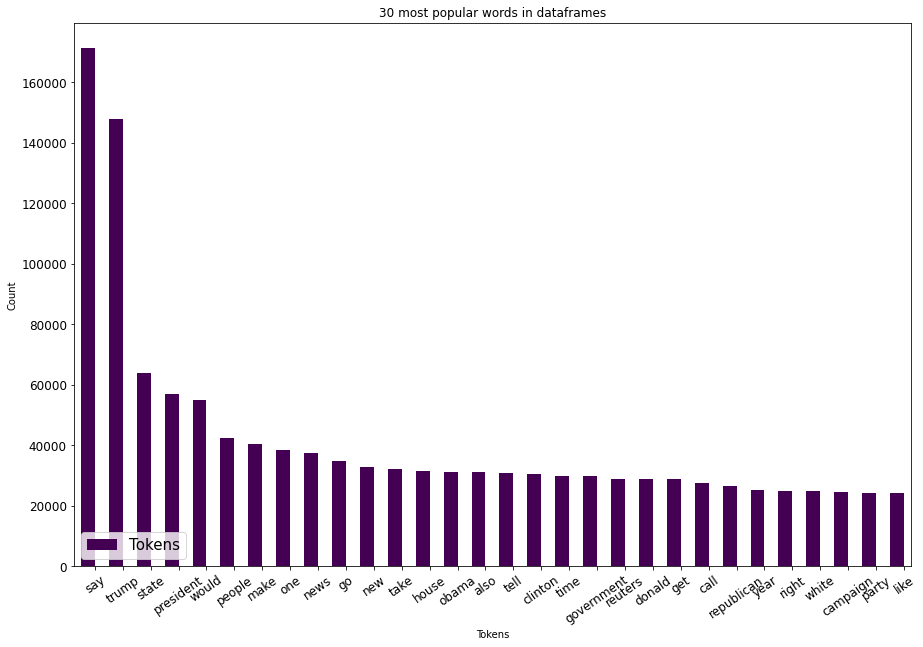

In [439]:
tokenized_df[:30].plot(kind="bar",x="word", orientation="vertical", figsize=(15,10), xlabel="Tokens", ylabel="Count", colormap="viridis", table=False, grid=False, fontsize=12, rot=35, position=1, title="30 most popular words in dataframes", legend=True).legend(["Tokens"], loc="lower left", prop={"size":15})

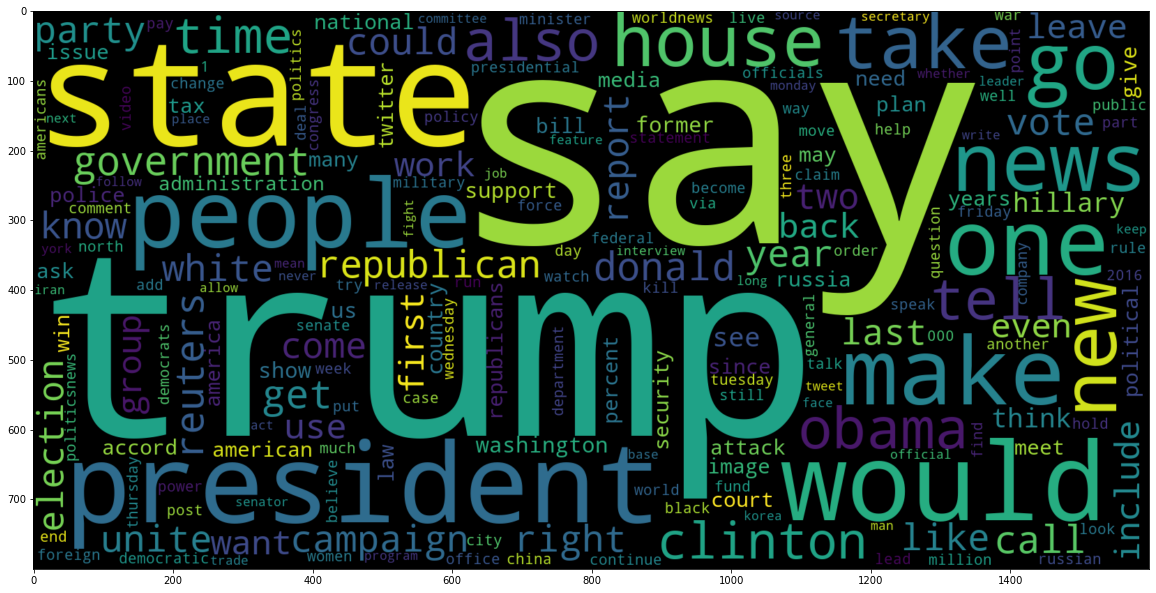

In [440]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words= 200, width = 1600, height= 800).generate_from_frequencies(tokenized_counts)
plt.imshow(wc, interpolation = 'bilinear')

<AxesSubplot:title={'center':'Longest 200 tweet/news lengths'}, xlabel='index', ylabel='word count'>

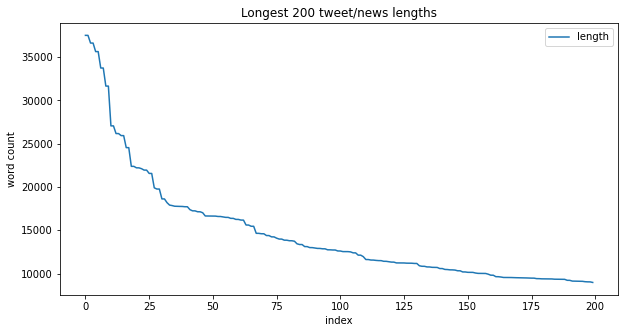

In [441]:
ctc = pd.concat([news_df['clean_text'], tweet_df['clean_text']])
length_df = pd.DataFrame(columns=['length'])
length_df['length'] = [len(i) for i in ctc]
length_df.sort_values(by=['length'], inplace=True, ascending=False)
length_df = length_df.reset_index(drop=True)
length_df[:200].plot(title="Longest 200 tweet/news lengths", figsize=(10,5), xlabel='index', ylabel='word count')

<AxesSubplot:>

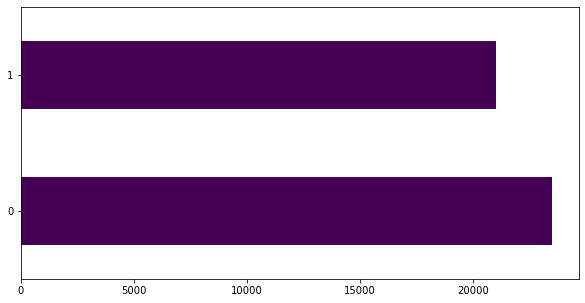

In [442]:
news_df['label'].value_counts().plot(kind='barh', figsize=(10,5), colormap="viridis")

In [443]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform([x for x in ctc])
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
say,1.188952
president,1.638434
would,1.673472
news,1.677359
trump,1.677403
...,...
kampuchea,11.009873
kamsikeaw,11.009873
kamyl,11.009873
kamilah,11.009873


<AxesSubplot:>

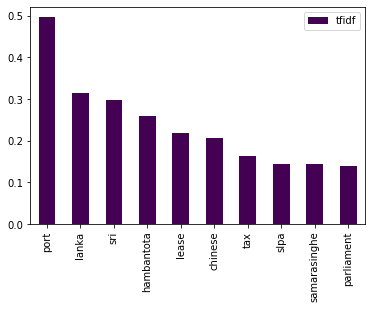

In [444]:
count_vector = cv.transform([x for x in ctc])
tf_idf_vector = tfidf_transformer.transform(count_vector)

feature_names = cv.get_feature_names_out()
first_document_vector=tf_idf_vector[0] 
tf_idf_df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
tf_idf_df = tf_idf_df.sort_values(by=["tfidf"],ascending=False)
tf_idf_df[:10].plot(kind="bar", colormap="viridis")

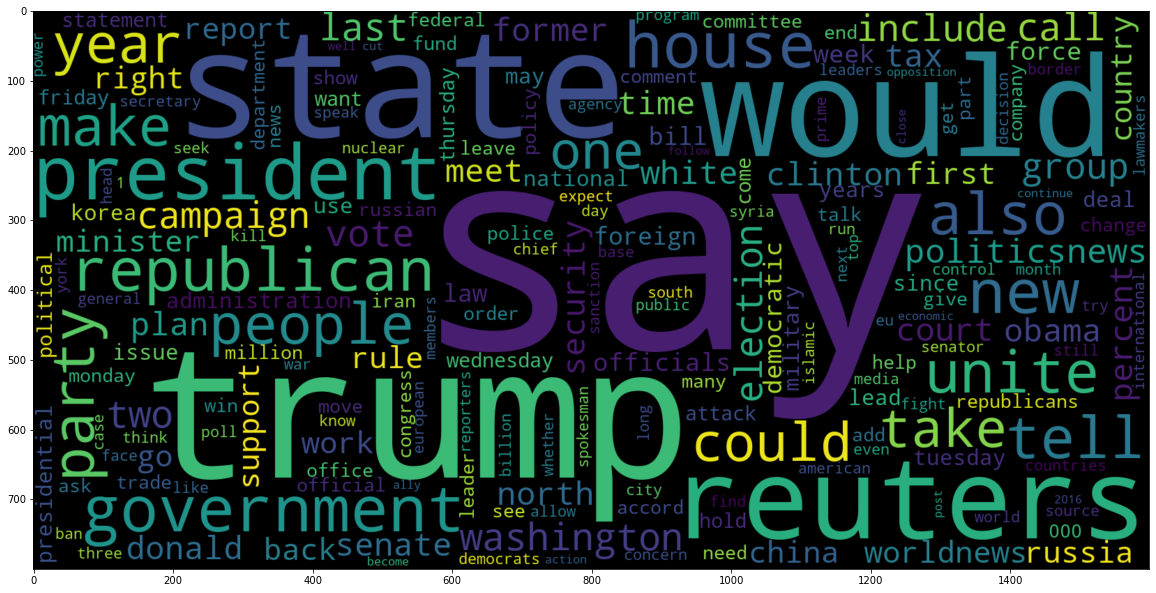

In [445]:
plt.figure(figsize=(20,20))
true_df = news_df[news_df['label'] == 1]
tokenizer_true = Tokenizer()
tokenizer_true.fit_on_texts([x for x in true_df['clean_text']])
tokenized_counts_true = Counter(tokenizer_true.word_counts)
wc_true = WordCloud(max_words= 200, width = 1600, height= 800).generate_from_frequencies(tokenized_counts_true)
plt.imshow(wc_true, interpolation = 'bilinear')

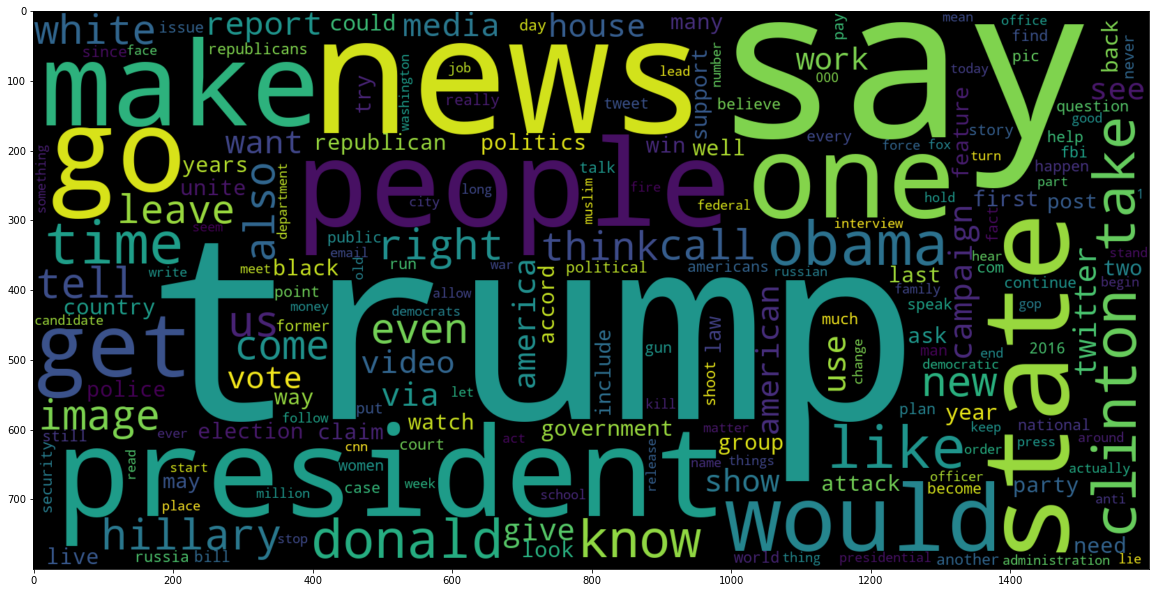

In [446]:
plt.figure(figsize=(20,20))
false_df = news_df[news_df['label'] == 0]
tokenizer_false = Tokenizer()
tokenizer_false.fit_on_texts([x for x in false_df['clean_text']])
tokenized_counts_false = Counter(tokenizer_false.word_counts)
wc_false = WordCloud(max_words= 200, width = 1600, height= 800).generate_from_frequencies(tokenized_counts_false)
plt.imshow(wc_false, interpolation = 'bilinear')

<AxesSubplot:title={'center':'20 Most frequently Occuring Bigrams (True Dataset)'}, ylabel='Bigram'>

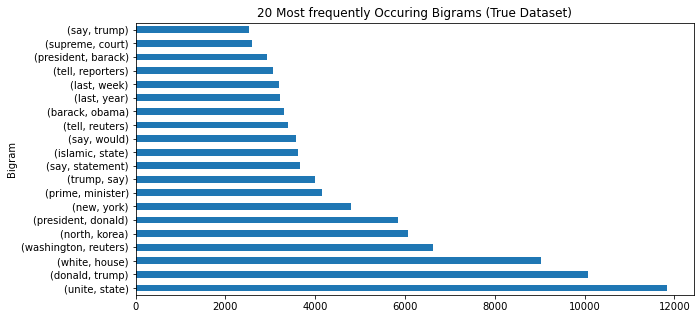

In [447]:
true_word = ''.join(true_df['clean_text'].tolist())
true_bigrams_series = pd.Series(ngrams(true_word.split(), 2))
true_bigrams_series = true_bigrams_series.value_counts()
true_bigrams_series = true_bigrams_series.sort_values(ascending=False)
true_bigrams_series[:20].plot(kind='barh', figsize=(10,5), xlabel='Bigram', ylabel='# of Occurances', title='20 Most frequently Occuring Bigrams (True Dataset)')

<AxesSubplot:title={'center':'20 Most frequently Occuring Bigrams (False Dataset)'}, ylabel='Bigram'>

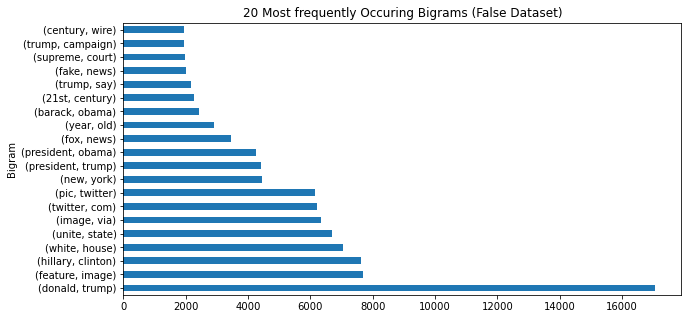

In [448]:
false_word = ''.join(false_df['clean_text'].tolist())
false_bigrams_series = pd.Series(ngrams(false_word.split(), 2))
false_bigrams_series = false_bigrams_series.value_counts()
false_bigrams_series = false_bigrams_series.sort_values(ascending=False)
false_bigrams_series[:20].plot(kind='barh', figsize=(10,5), xlabel='Bigram', ylabel='# of Occurances', title='20 Most frequently Occuring Bigrams (False Dataset)')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(news_df['sequence'], news_df['label'], random_state=0)

33363
33363


In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

33363


In [512]:
size = len(tokenizer.word_index) + 1

model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 100)          1000000   
_________________________________________________________________
lstm_22 (LSTM)               (None, 300, 128)          117248    
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [513]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
92/92 [==============================] - 192s 2s/step - loss: 0.6821 - accuracy: 0.5552 - val_loss: 0.6212 - val_accuracy: 0.6174
Epoch 2/10
92/92 [==============================] - 181s 2s/step - loss: 0.7264 - accuracy: 0.5153 - val_loss: 0.6917 - val_accuracy: 0.5263
Epoch 3/10
16/92 [====>.........................] - ETA: 2:31 - loss: 0.6913 - accuracy: 0.5320

KeyboardInterrupt: 